In [3]:
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import analyze

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 1
%aimport analyze

with open('plots/style.json') as f:
    mpl.rcParams.update(json.load(f))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Results

In [1]:
system = "frontier"
version = "v0.6.0"
oldversion = "v0.5.3"

## Current

In [4]:
new = analyze.Analysis(f"results/{system}/")
print(new)

Analysis for Celeritas v0.6.0-rc.3 on frontier


In [5]:
analyze.calc_geo_frac(new)

count      mean       std
problem                     geo    arch                           
atlas-tilecal               orange cpu     7.0  0.786721  0.017006
cms-hgcal                   orange cpu     7.0  0.684885  0.000527
testem15                    orange cpu     7.0  0.431873  0.000787
testem15+field              orange cpu     7.0  0.539747  0.000402
                                   gpu     7.0  0.574332  0.000886
testem15+field+msc          orange cpu     7.0  0.629262  0.000513
testem3-composite+field+msc orange cpu     7.0  0.752111  0.000665
                                   gpu     7.0  0.895797  0.003071
testem3-composite+msc       orange cpu     7.0  0.715094  0.001046
testem3-expanded+field+msc  orange cpu     7.0  0.765768  0.000439
testem3-flat                orange cpu     7.0  0.672518  0.000570
testem3-flat+field          orange cpu     7.0  0.715370  0.000597
testem3-flat+field+msc      orange cpu     7.0  0.788673  0.000850
                                   gpu     7.0  0.867683  0.000625
testem3-flat+msc            orange cpu     7.0  0.762195  0.001232

## Previous

In [6]:
old = analyze.Analysis(f"results-old/{system}/")
print(old, f"({oldversion})")

Analysis for Celeritas v0.5.3-rc.1 on frontier (v0.5.3)


In [7]:
ftab = analyze.make_failure_table(old.failures())
ftab.to_frame()

,Failure


# Analysis

## Compare manually

In [12]:
GEOMETRY = 'orange'

def get_throughput(analysis):
    col = analysis.result['avg_event_per_time']
    return col.xs(GEOMETRY, level='geo').unstack('arch')

def get_slots_per_stream(analysis):
    col = analysis.input['num_track_slots']
    return col.xs(GEOMETRY, level='geo').unstack('arch')

def compare(func):
    return 

In [13]:
def get_num_streams(analysis):
    c = new.cpu_per_task
    return pd.Series({'g4': np.nan, 'cpu': c,  'gpu': 1, 'cpu+g4': c, 'gpu+g4': 1})

def get_total_slots(analysis):
    return get_num_streams(analysis) * get_slots_per_stream(analysis)

In [15]:
rel_throughput = get_throughput(new) / get_throughput(old) - 1

In [16]:
rel_throughput.groupby('problem').mean()

arch,cpu,cpu+g4,gpu,gpu+g4,gpu+sync
problem,,,,,
atlas-tilecal,-0.181893,-0.142194,-0.391065,-0.394557,NaN
cms-hgcal,-0.016991,-0.012190,-0.072509,-0.006632,NaN
testem15,-0.027556,-0.004927,-0.122912,-0.087210,NaN
testem15+field,-0.016851,-0.025814,-0.262317,-0.197930,-0.251610
testem15+field+msc,-0.006920,-0.007845,-0.225201,-0.187165,NaN
testem3-composite+field+msc,-0.021138,-0.004338,-0.252306,-0.218529,-0.249874
testem3-composite+msc,-0.029218,0.007565,-0.155385,-0.122119,NaN
testem3-expanded+field+msc,-0.007618,-0.019523,-0.253722,-0.210324,NaN
testem3-flat,-0.009768,-0.018093,0.327835,0.128163,NaN


In [17]:
get_total_slots(new) / get_total_slots(old)

,cpu,cpu+g4,g4,gpu,gpu+g4,gpu+sync
problem,,,,,,
atlas-tilecal,1.0,1.0,NaN,1.0,1.0,NaN
cms-hgcal,1.0,1.0,NaN,1.0,1.0,NaN
testem15+field+msc,1.0,1.0,NaN,1.0,1.0,NaN
testem15+field,1.0,1.0,NaN,1.0,1.0,NaN
testem15,1.0,1.0,NaN,1.0,1.0,NaN
testem3-composite+field+msc,1.0,1.0,NaN,1.0,1.0,NaN
testem3-composite+msc,1.0,1.0,NaN,1.0,1.0,NaN
testem3-expanded+field+msc,1.0,1.0,NaN,1.0,1.0,NaN
testem3-flat+field+msc,1.0,1.0,NaN,1.0,1.0,NaN


In [18]:
get_slots_per_stream(new).iloc[1]

arch
cpu           28672.0
cpu+g4         4096.0
gpu         1048576.0
gpu+g4       262144.0
gpu+sync          NaN
Name: cms-hgcal, dtype: float64

In [19]:
get_slots_per_stream(old).iloc[1]

arch
cpu           28672.0
cpu+g4         4096.0
gpu         1048576.0
gpu+g4       262144.0
gpu+sync          NaN
Name: cms-hgcal, dtype: float64

# Kernel stat comparison

In [63]:
def load_kernels(analysis, problem, geo):
    kernels = pd.DataFrame(analyze.load_kernels(analysis, problem, geo))
    kernels.index = kernels.pop('name')
    kernels["register_mem"] = kernels.pop("num_regs") * analyze.BYTES_PER_REG
    return kernels

def total_mem(kernels):
    return kernels['register_mem'] + kernels['local_mem']

new_gpu_times = new.action_times().xs('gpu+sync', level='arch')
new_kernel_stats = load_kernels(new, "testem3-flat+field+msc", GEOMETRY)

old_gpu_times = old.action_times().xs('gpu+sync', level='arch')
old_kernel_stats = load_kernels(old, "testem3-flat+field+msc", GEOMETRY)

In [117]:
cmap = mpl.colormaps["tab20c"] # 5 groups of 4 shades
def _get_color(color, shade = 0):
    shade = shade % 4
    return cmap((color % 5) * 4 + shade)

def annotate_rel(ax):
    return ax.text(0.98, 0.02,
        f"{version} vs {oldversion} on {system}",
        va='bottom', ha='right',
        fontstyle='italic', color=(0.5,)*3, size='xx-small',
        transform=ax.transAxes,
        zorder=-100
    )

def plot_manual_ratio(ratio):
    (fig, ax) = plt.subplots(1, 1)
    colors = np.array([_get_color(analyze.get_action_priority(name)) for name in ratio.index])
    ax.scatter(range(len(ratio)), ratio, c=colors)
    ax.set_xticklabels(ratio.index, rotation=90)
    ax.set_xticks(range(len(ratio)))
    ax.axhline(1.0, color='grey', linestyle='-', linewidth=0.8, zorder=-1)
    annotate_rel(ax)
    
    ymin_dat, ymax_dat = ax.get_ylim()
    for i, val in enumerate(ratio):
        if val != 1.0:
            ax.axvline(i, ymin=0, ymax=(val - ymin_dat) / (ymax_dat - ymin_dat), color='grey', linestyle='--', linewidth=0.5, zorder=-2)
    return (fig, ax)


/var/folders/n9/mqnx20b929z469f6p3fbq7c40000gn/T/ipykernel_33264/857405401.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ratio.index, rotation=90)


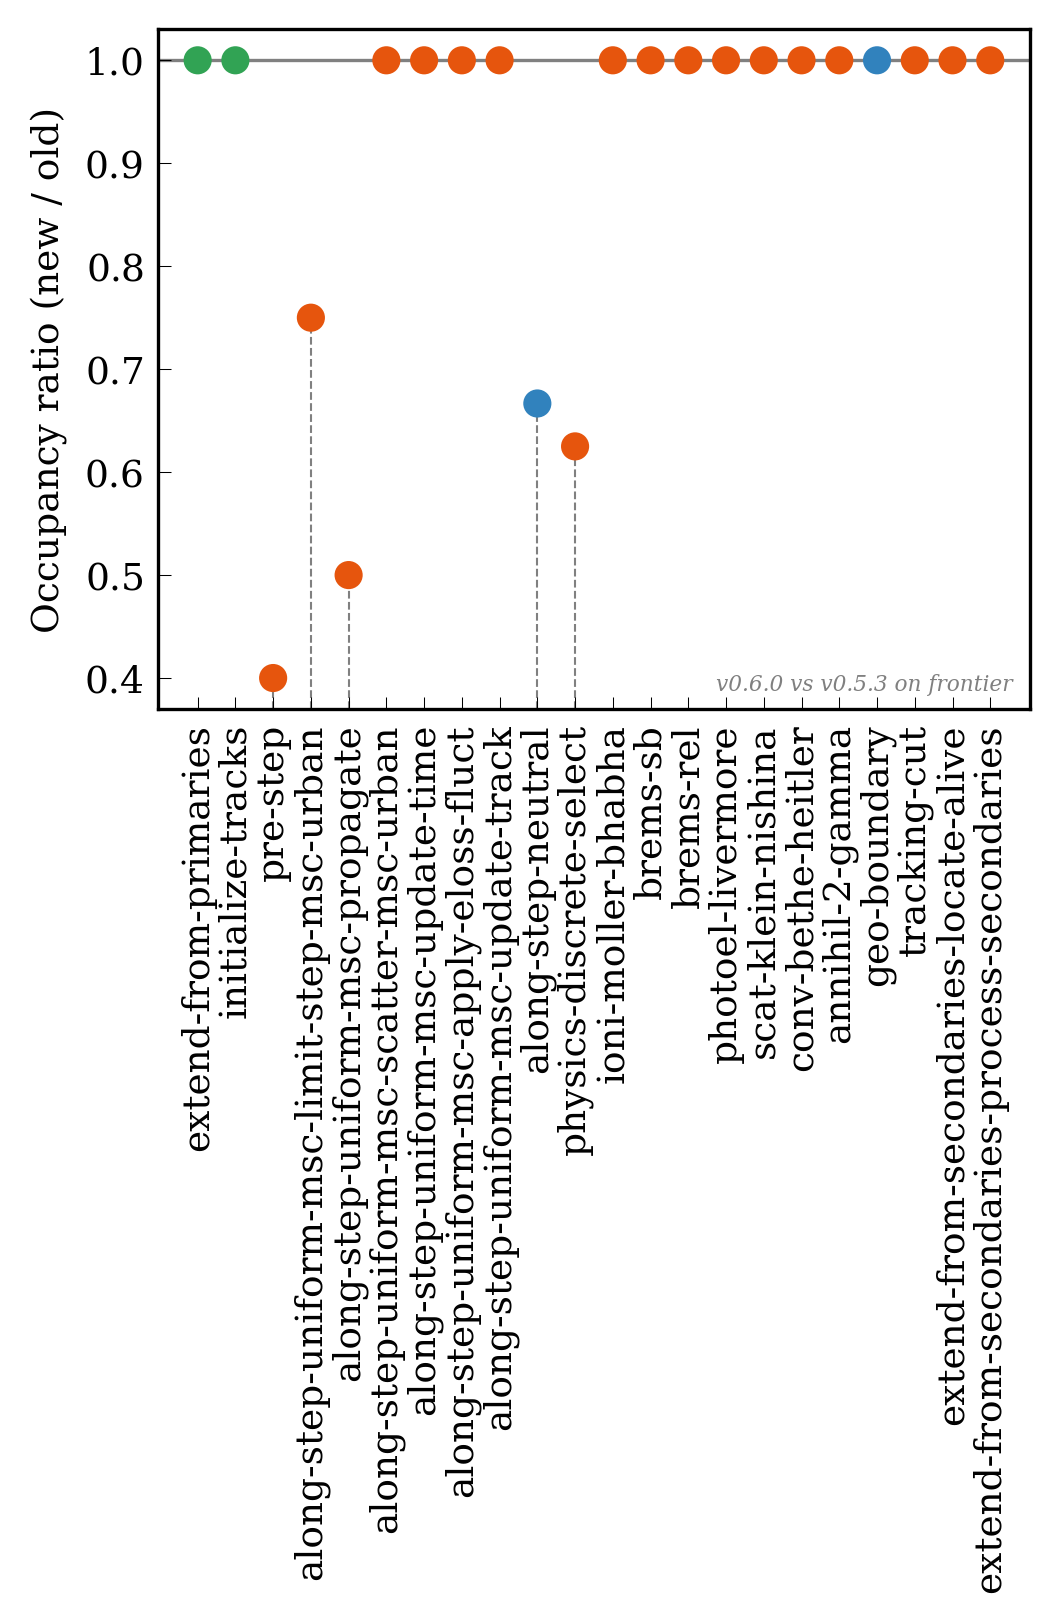

In [118]:
(fig, ax) = plot_manual_ratio(new_kernel_stats["occupancy"] / old_kernel_stats["occupancy"])
ax.set_ylabel('Occupancy ratio (new / old)')
ax.get_figure().savefig(f"results-old/{system}/rel-occupancy.png")

/var/folders/n9/mqnx20b929z469f6p3fbq7c40000gn/T/ipykernel_33264/857405401.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ratio.index, rotation=90)


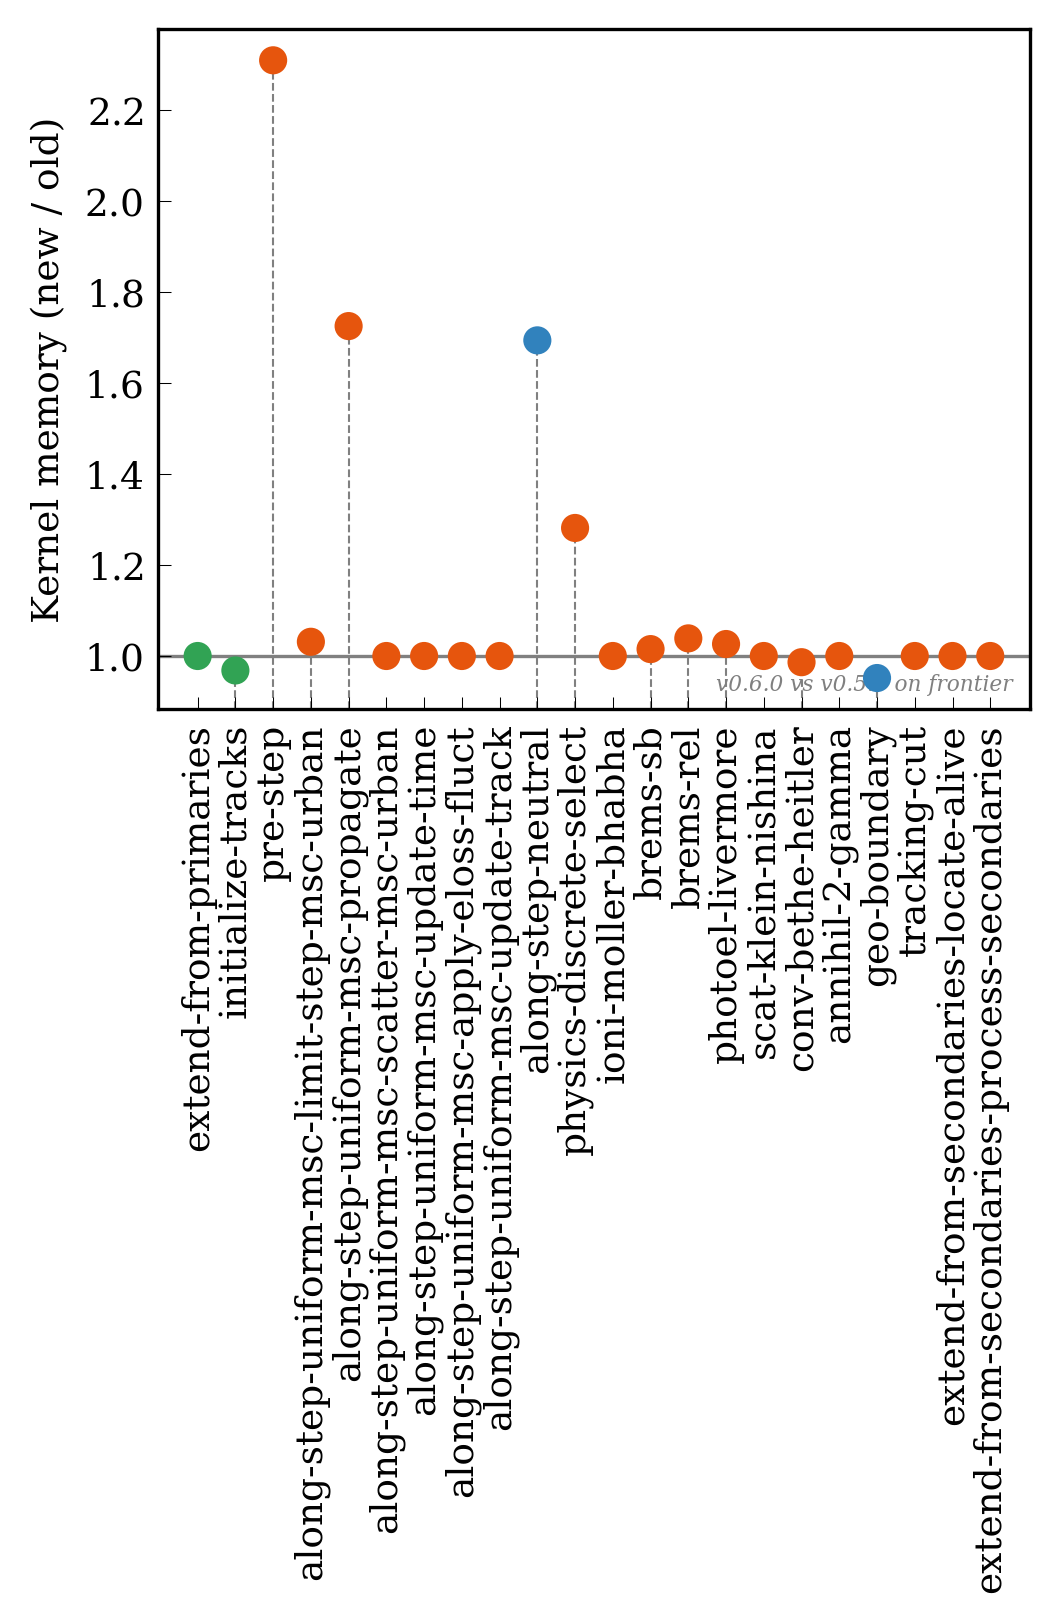

In [119]:
(fig, ax) = plot_manual_ratio(total_mem(new_kernel_stats) / total_mem(old_kernel_stats))
ax.set_ylabel('Kernel memory (new / old)')
ax.get_figure().savefig(f"results-old/{system}/rel-memory.png")

## Performance drop between versions

In [23]:
#analyses = {a.version: a for a in [frontier, frontier_v050]}
analyses = {
    oldversion: old,
    version: new,
}
throughput = {k: a.result['avg_event_per_time'] for k, a in analyses.items()}
plot_rel_to = old

In [ ]:
def plot_ratio(result_dict):
    rel = analyze.summarize_instances(result_dict[version] / result_dict[oldversion])
    rel.dropna(inplace=True)
    fig, ax = plt.subplots(layout="constrained")
    plot_rel_to.plot_results(ax, rel)
    ax.grid(which='both')
    ax.legend()
    annotate_rel(ax)

    return ax

In [25]:
steps = {k: a.result['avg_steps_per_primary'] for k, a in analyses.items()}

In [26]:
ax = plot_ratio(throughput)
ax.set_ylabel(f"Throughput [events/sec]")
ax.get_figure().savefig(f"results-old/{system}/rel-throughput.png", dpi=300)
ax.get_figure().savefig(f"results-old/{system}/rel-throughput.pdf", transparent=True)
plt.close()

In [27]:
ax = plot_ratio(steps)
ax.set_ylabel(f"Work [steps/primary]")
ax.get_figure().savefig(f"results-old/{system}/rel-work.png", dpi=300)
ax.get_figure().savefig(f"results-old/{system}/rel-work.pdf", transparent=True)
plt.close()

In [28]:
!open results-old/{system}

In [50]:
new_kernel_stats / old_kernel_stats

,const_mem,heap_size,local_mem,max_blocks_per_cu,max_threads_per_block,max_warps_per_eu,occupancy,print_buffer_size,threads_per_block,register_mem
name,,,,,,,,,,
extend-from-primaries,NaN,1.0,NaN,1.0,1.0,1.0,1.0,NaN,1.0,1.0
initialize-tracks,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0
pre-step,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0
along-step-uniform-msc-limit-step-msc-urban,NaN,1.0,NaN,1.0,1.0,1.0,1.0,NaN,1.0,1.0
along-step-uniform-msc-propagate,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0
along-step-uniform-msc-scatter-msc-urban,NaN,1.0,NaN,1.0,1.0,1.0,1.0,NaN,1.0,1.0
along-step-uniform-msc-update-time,NaN,1.0,NaN,1.0,1.0,1.0,1.0,NaN,1.0,1.0
along-step-uniform-msc-apply-eloss-fluct,NaN,1.0,NaN,1.0,1.0,1.0,1.0,NaN,1.0,1.0
along-step-uniform-msc-update-track,NaN,1.0,NaN,1.0,1.0,1.0,1.0,NaN,1.0,1.0
